In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, GroupKFold, StratifiedGroupKFold, KFold
import random
from collections import Counter
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_palette('bright')

### GET DFs - ALL, CHRONO, CHAR, LOC, FAC, VEH, GPE, TIME, PATIENT, AGENT, ADJ 

#### DF_ALL

In [3]:
df_ALL = pd.read_csv(r'data_doc2vec/ALL_embeddings.csv')
df_ALL.set_index("doc", inplace = True)
df_ALL = df_ALL.replace(np.nan, 0)

In [4]:
df_ALL.shape

(2944, 300)

#### DF_CHRONO

In [5]:
df_CHRONO = pd.read_csv(r'data_doc2vec/CHRONO_embeddings.csv')
df_CHRONO.set_index("doc", inplace = True)
df_CHRONO = df_CHRONO.replace(np.nan, 0)
df_CHRONO.shape

(2944, 300)

In [6]:
df_CHAR = pd.read_csv(r'data_doc2vec/CHAR_embeddings.csv')
df_CHAR.set_index("doc", inplace = True)
df_CHAR = df_CHAR.replace(np.nan, 0)
df_CHAR.shape

(2944, 300)

In [7]:
df_AGENT = pd.read_csv(r'data_doc2vec/AGENT_embeddings.csv')
df_AGENT.set_index("doc", inplace = True)
df_AGENT = df_AGENT.replace(np.nan, 0)
df_AGENT.shape

(2944, 300)

In [8]:
df_PATIENT = pd.read_csv(r'data_doc2vec/PATIENT_embeddings.csv')
df_PATIENT.set_index("doc", inplace = True)
df_PATIENT = df_PATIENT.replace(np.nan, 0)
df_PATIENT.shape

(2944, 300)

In [9]:
df_ADJ = pd.read_csv(r'data_doc2vec/ADJ_embeddings.csv')
df_ADJ.set_index("doc", inplace = True)
df_ADJ = df_ADJ.replace(np.nan, 0)
df_ADJ.shape

(2944, 300)

In [10]:
df_LOC = pd.read_csv(r'data_doc2vec/LOC_embeddings.csv')
df_LOC.set_index("doc", inplace = True)
df_LOC = df_LOC.replace(np.nan, 0)
df_LOC.shape

(2944, 300)

In [11]:
df_FAC = pd.read_csv(r'data_doc2vec/FAC_embeddings.csv')
df_FAC.set_index("doc", inplace = True)
df_FAC = df_FAC.replace(np.nan, 0)
df_FAC.shape

(2944, 300)

In [12]:
df_GPE = pd.read_csv(r'data_doc2vec/GPE_embeddings.csv')
df_GPE.set_index("doc", inplace = True)
df_GPE = df_GPE.replace(np.nan, 0)
df_GPE.shape

(2944, 300)

In [13]:
df_VEH = pd.read_csv(r'data_doc2vec/VEH_embeddings.csv')
df_VEH.set_index("doc", inplace = True)
df_VEH = df_VEH.replace(np.nan, 0)
df_VEH.shape

(2944, 300)

In [14]:
df_TIME = pd.read_csv(r'data_doc2vec/TIME_embeddings.csv')
df_TIME.set_index("doc", inplace = True)
df_TIME = df_TIME.replace(np.nan, 0)
df_TIME.shape

(2944, 300)

### GET DF_BoW

In [15]:
df_BoW = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/data/main_dataset_majed_canon_author_scale.csv')
df_BoW.set_index("index", inplace = True)
df_BoW = df_BoW.replace(np.nan, 0)

In [16]:
df_BoW = df_BoW.iloc[:, 0:600]#1000

In [17]:
df_BoW.index = [elem.split(".")[0] for elem in list(df_BoW.index)]
df_BoW = df_BoW[~df_BoW.index.duplicated(keep='first')]

In [18]:
df_BoW.shape

(2953, 600)

### DF MAIN : ALL CONCATENATED DFs

In [19]:
def get_common_items(list1, list2):
    # Find the intersection of all four lists
    common_items = list(set(list1) & set(list2))
    all_items = set([*list1, *list2])

    faulty_items = [elem for elem in all_items if elem not in common_items]
    
    return common_items, faulty_items, all_items


In [20]:
common_items, faulty_items, all_items = get_common_items(df_ALL.index, df_BoW.index)

In [21]:
print(len(common_items), len(faulty_items), len(all_items))

2907 83 2990


In [22]:
faulty_items

['1947_Laurent-Jacques_Caroline-Cherie-T.2',
 '1876_Peregrine-D',
 '1859_Saintine-X-B._Metamorphoses-de-la-femme',
 '1883_Millanvoye-Bertrand-Etievant-A._Les-Coquines',
 '2011_Djian-Philippe_Vengeances',
 '1836_Igonette-T._Le-Valmont-de-la-jeunesse_ou-le-Triomphe-des-vertus-sur-les-egarements-de-la-raison-mis-a-la-portee-des-jeunes-gens-des-deux-sexes__tome-2)',
 '1974_Laine-Pascal_La-dentelliere',
 '1836_Igonette-T._Le-Valmont-de-la-jeunesse_ou-le-Triomphe-des-vertus-sur-les-egarements-de-la-raison-mis-a-la-portee-des-jeunes-gens-des-deux-sexes__tome-1)',
 '1947_Laurent-Jacques_Caroline-Cherie-T.1',
 '1859_Saintine-X-B',
 '1879_Thuret-Mme-E._La-Guerre-au-chateau',
 '1973_A.D.G._Berry-Story',
 '1881_R-L._Un-amour-heureux',
 '1972_A.D.G._La-marche-truque',
 '1980_A',
 '1972_A.D.G._Cradoque-s-band',
 '1971_A',
 '1826_Ginouvier-J-F-T._Gustave-et-Aspais-ou-Les-victimes-des-prejuges-de-l-epoque_tome-3',
 '1881_Erckmann-Chatrian_Les-Vieux-de-la-Vieille-Justine-et-Lucien',
 '1876_Peregrine-D.

In [23]:
print(df_ALL.shape, df_BoW.shape)

(2944, 300) (2953, 600)


In [24]:
df_ALL.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_CHAR.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_CHRONO.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_AGENT.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_PATIENT.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_ADJ.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_LOC.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_FAC.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_GPE.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_VEH.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_TIME.drop(faulty_items, axis=0, inplace=True, errors='ignore')

df_BoW.drop(faulty_items, axis=0, inplace=True, errors='ignore')

In [25]:
df_CHRONOCHAR_CONCAT = pd.concat([df_CHRONO, df_CHAR], axis=1)

In [26]:
df_MAIN_CONCAT = pd.concat([df_AGENT, df_PATIENT, df_ADJ, df_LOC, df_FAC, df_GPE, df_VEH, df_TIME], axis=1)

## GET GENRES

In [27]:
df_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/corpus.csv')
df_corpus.set_index(['doc_name'], inplace=True)

In [53]:
genres_ok = ["roman d'aventures",
'policier',
'littérature jeunesse',
'mémoires et autobiographie',
'roman sentimental']
#'roman historique',

In [54]:
def get_df_with_subgenre(df, df_corpus, genres_ok):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            if df_corpus.loc[elem].genre in genres_ok:
                list_subgenre.append(df_corpus.loc[elem].genre)
            else:
                list_subgenre.append('')
        else:
            list_subgenre.append('')
    df_res['subgenre'] = list_subgenre

    return df_res[df_res['subgenre'] != '']

In [55]:
df_ALL_genred = get_df_with_subgenre(df_ALL, df_corpus, genres_ok)
df_CHRONOCHAR_CONCAT_genred = get_df_with_subgenre(df_CHRONOCHAR_CONCAT, df_corpus, genres_ok)
df_MAIN_CONCAT_genred = get_df_with_subgenre(df_MAIN_CONCAT, df_corpus, genres_ok)
df_BOW_genred = get_df_with_subgenre(df_BoW, df_corpus, genres_ok)

In [56]:
df_ALL_genred.subgenre.value_counts()

subgenre
roman d'aventures             361
policier                      296
littérature jeunesse          144
mémoires et autobiographie    136
roman sentimental             130
Name: count, dtype: int64

### GET AUTHORS

In [57]:
def get_df_with_authors(df):
    df_res = df.copy()
    list_author = []
    for elem in df_res.index:
        list_author.append(elem.split('_')[1])
    df_res['auteur'] = list_author

    return df_res

In [58]:
df_ALL_authored = get_df_with_authors(df_ALL_genred)
df_CHRONOCHAR_CONCAT_authored = get_df_with_authors(df_CHRONOCHAR_CONCAT_genred)
df_MAIN_CONCAT_authored = get_df_with_authors(df_MAIN_CONCAT_genred)
df_BOW_authored = get_df_with_authors(df_BOW_genred)

In [59]:
def balance_dataframe(df, subgenre_column, N):
    # Count the occurrences of each subgenre
    subgenre_counts = df[subgenre_column].value_counts()
    
    # Determine the minimum count among all subgenres
    min_count = N
    
    # Create an empty DataFrame to store the balanced samples
    balanced_df = pd.DataFrame()
    
    # Iterate over each subgenre
    for i, subgenre in enumerate(subgenre_counts.index):
        # Sample `min_count` number of rows for each subgenre
        sampled_rows = df[df[subgenre_column] == subgenre].sample(n=min(min_count, subgenre_counts.values[i]), random_state=42)
        
        # Append the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sampled_rows])
    
    return shuffle(balanced_df)

In [60]:
df_ALL_balanced = balance_dataframe(df_ALL_authored, 'subgenre', 130)
df_CHRONOCHAR_CONCAT_balanced = balance_dataframe(df_CHRONOCHAR_CONCAT_authored, 'subgenre', 130)
df_MAIN_CONCAT_balanced = balance_dataframe(df_MAIN_CONCAT_authored, 'subgenre', 130)
df_BOW_balanced = balance_dataframe(df_BOW_authored, 'subgenre', 130)

In [61]:
df_ALL_balanced.subgenre.value_counts()

subgenre
roman sentimental             130
mémoires et autobiographie    130
policier                      130
littérature jeunesse          130
roman d'aventures             130
Name: count, dtype: int64

In [62]:
df_ALL_balanced.shape

(650, 302)

### SVM PIPELINE

In [63]:
def plot_coefficients(coefs, feature_names, current_class, top_features=15):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    fig, ax = plt.subplots(figsize=(15, 5))

    colors = ['policier' if c < 0 else 'random' for c in coefs[top_coefficients]]
    feature_names = np.array(feature_names)
    zipped = list(zip(feature_names, coefs[top_coefficients], colors))
    df_tmp = pd.DataFrame(zipped, columns=['features', 'coefs', 'colors'])
    
    sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())

    ax.set_xlabel('Feature name', fontsize = 30)
    ax.set_ylabel('Coefficient score', fontsize = 30)
    
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    plt.title("Coefficients for Policier")

    plt.savefig('img/COEFS_'+current_class+'.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()
    

In [68]:
def GKF_canonized(df_main, name_features, n_splits=5, probas=False, kernel='rbf', get_coefs=False):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions & all ground truth data
    ALL_INDEX = [] # lists of all test probas and all test index
    ALL_PROBA_AVENTURES, ALL_PROBA_JEUNESSE, ALL_PROBA_POLICIER, ALL_PROBA_AUTOBIO, ALL_PROBA_SENTIMENT = [], [], [], [], []    
    
    pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=probas))
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'subgenre'], axis=1), df_main['subgenre'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'subgenre'], axis=1)
            y_train = train['subgenre']
            X_test = test.drop(['auteur', 'subgenre'], axis=1)
            y_test = test['subgenre']
        
            pipe.fit(X_train, y_train) 
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)
                ALL_PROBA_JEUNESSE.extend(probs[:,0])
                ALL_PROBA_AUTOBIO.extend(probs[:,1])
                ALL_PROBA_POLICIER.extend(probs[:,2])
                ALL_PROBA_AVENTURES.extend(probs[:,3])
                ALL_PROBA_SENTIMENT.extend(probs[:,4])
        
    cm = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)
    plt.tight_layout()

    # get translated labels for CM png
    ax = cm.ax_
    translated_genres = ['Children', 'Memoirs', 'Detective', 'Adventure', 'Romance']
    ax.set_xticklabels(translated_genres, rotation="vertical")
    ax.set_yticklabels(translated_genres)

    cm.figure_.savefig('img/CM_'+name_features+'_GKF.png', dpi=300)

    

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    print(df_scores)
    print(bas)
     
    if get_coefs:
        if kernel != "linear":
            print(".......... COEFS ARE ONLY IMPLEMENTED FOR linearSVC ........")

        else:
            if len(pipe.classes_) == 2:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 index=[pipe.classes_[0]],
                                 columns=X_train.columns+['subgenre']).to_csv("coefficients_1V1.csv")

                plot_coefficients(pipe.named_steps['svc'].coef_[0], X_train.columns, pipe.classes_[0] + " versus " + pipe.classes_[1])

            else:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 #index=pipe.classes_,
                                 columns=X_train.columns+['subgenre']).to_csv("coefficients_subgenres.csv")

                for i in range(len(pipe.classes_)):
                    plot_coefficients(pipe.named_steps['svc'].coef_[i], X_train.columns, pipe.classes_[i])
            
    if probas:
        
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_jeunesse'] = ALL_PROBA_JEUNESSE
        df_results['proba_aventures'] = ALL_PROBA_AVENTURES
        df_results['proba_policier'] = ALL_PROBA_POLICIER
        df_results['proba_autobio'] = ALL_PROBA_AUTOBIO
        df_results['proba_sentiment'] = ALL_PROBA_SENTIMENT
        df_results['prediction']= ALL_PREDS
        df_results['index'] = ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        df_results.set_index('index').to_csv('output_svm/'+name_features+'_probas.csv')
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

### MULTICLASS CLASSIFICATION SUBGENRES

In [69]:
print(df_ALL_balanced.shape, df_CHRONOCHAR_CONCAT_balanced.shape, df_MAIN_CONCAT_balanced.shape, df_BOW_balanced.shape)

(650, 302) (650, 602) (650, 2402) (650, 602)


### RESULTS BOW

['littérature jeunesse' 'mémoires et autobiographie' 'policier'
 "roman d'aventures" 'roman sentimental']
                            precision    recall  f1-score     support
littérature jeunesse         0.613636  0.830769  0.705882  130.000000
mémoires et autobiographie   0.769231  0.846154  0.805861  130.000000
policier                     0.773585  0.630769  0.694915  130.000000
roman d'aventures            0.613497  0.769231  0.682594  130.000000
roman sentimental            0.983871  0.469231  0.635417  130.000000
accuracy                     0.709231  0.709231  0.709231    0.709231
0.7092307692307692
\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
littérature jeunesse & 0.613636 & 0.830769 & 0.705882 & 130.000000 \\
mémoires et autobiographie & 0.769231 & 0.846154 & 0.805861 & 130.000000 \\
policier & 0.773585 & 0.630769 & 0.694915 & 130.000000 \\
roman d'aventures & 0.613497 & 0.769231 & 0.682594 & 130.000000 \\
roman sentimental & 0.98387

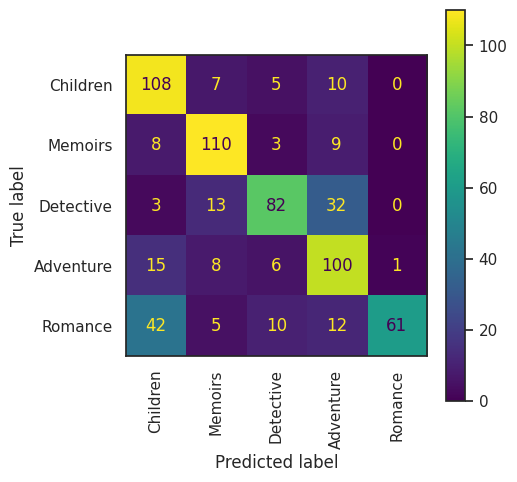

In [66]:
pipe, df_scores, bas, df_probas = GKF_canonized(df_BOW_balanced, 'BOW', probas=True)
print(df_scores.to_latex())

In [ ]:
pipe, df_scores, bas = KF_canonized(df_BOW_balanced)
print(df_scores.to_latex())

                            precision    recall  f1-score     support
littérature jeunesse         0.786765  0.823077  0.804511  130.000000
mémoires et autobiographie   0.825758  0.838462  0.832061  130.000000
policier                     0.725806  0.692308  0.708661  130.000000
roman d'aventures            0.611111  0.761538  0.678082  130.000000
roman sentimental            0.906250  0.669231  0.769912  130.000000
accuracy                     0.756923  0.756923  0.756923    0.756923
0.7569230769230768


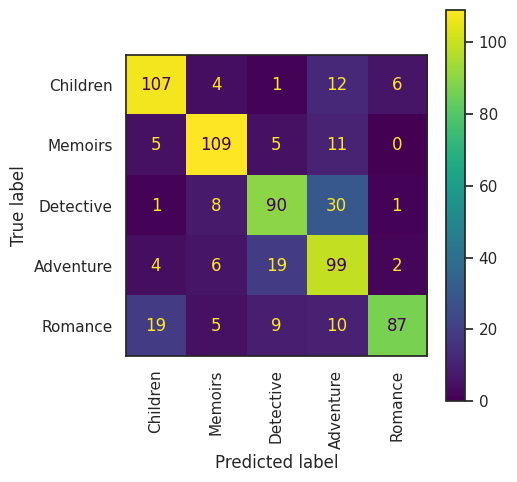

In [203]:
pipe, df_scores, bas = GKF_canonized(df_BOW_balanced, 'BOW', kernel="linear")

                            precision    recall  f1-score     support
littérature jeunesse         0.915254  0.830769  0.870968  130.000000
mémoires et autobiographie   0.870504  0.930769  0.899628  130.000000
policier                     0.877049  0.823077  0.849206  130.000000
roman d'aventures            0.780142  0.846154  0.811808  130.000000
roman sentimental            0.946154  0.946154  0.946154  130.000000
accuracy                     0.875385  0.875385  0.875385    0.875385
0.8753846153846153


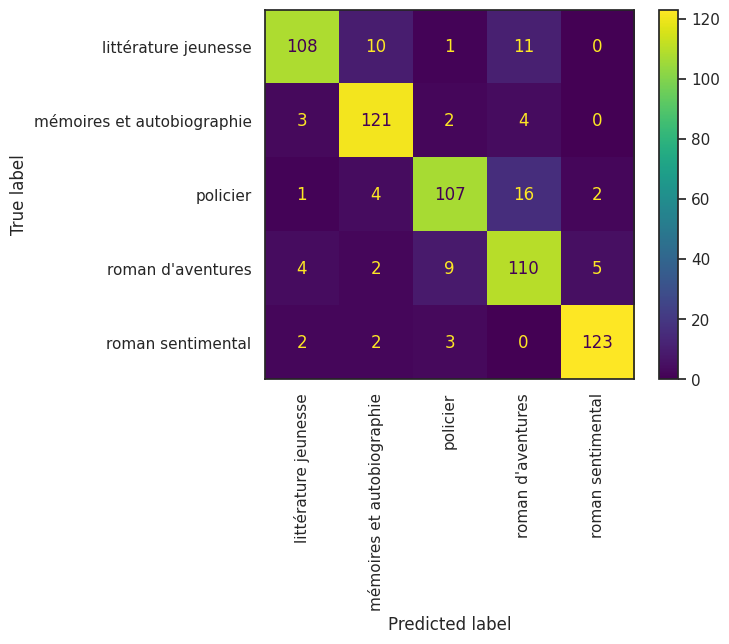

In [126]:
pipe, df_scores, bas = KF_canonized(df_BOW_balanced, kernel="linear")

In [142]:
print(df_scores.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
littérature jeunesse & 0.750000 & 0.784615 & 0.766917 & 130.000000 \\
mémoires et autobiographie & 0.820896 & 0.846154 & 0.833333 & 130.000000 \\
policier & 0.706349 & 0.684615 & 0.695313 & 130.000000 \\
roman d'aventures & 0.628205 & 0.753846 & 0.685315 & 130.000000 \\
roman sentimental & 0.928571 & 0.700000 & 0.798246 & 130.000000 \\
accuracy & 0.753846 & 0.753846 & 0.753846 & 0.753846 \\
\bottomrule
\end{tabular}



### RESULTS ALL

['littérature jeunesse' 'mémoires et autobiographie' 'policier'
 "roman d'aventures" 'roman sentimental']
                            precision    recall  f1-score     support
littérature jeunesse         0.651613  0.776923  0.708772  130.000000
mémoires et autobiographie   0.780822  0.876923  0.826087  130.000000
policier                     0.714286  0.615385  0.661157  130.000000
roman d'aventures            0.666667  0.784615  0.720848  130.000000
roman sentimental            0.892857  0.576923  0.700935  130.000000
accuracy                     0.726154  0.726154  0.726154    0.726154
0.726153846153846


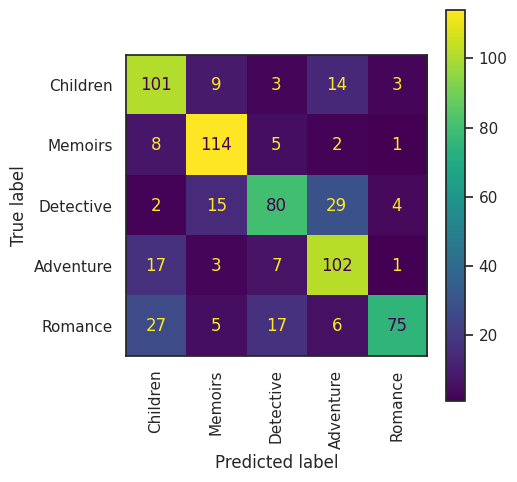

In [67]:
pipe, df_scores, bas, df_probas = GKF_canonized(df_ALL_balanced, 'ALL', probas=True)

                            precision    recall  f1-score     support
littérature jeunesse         0.640523  0.753846  0.692580  130.000000
mémoires et autobiographie   0.805970  0.830769  0.818182  130.000000
policier                     0.779661  0.707692  0.741935  130.000000
roman d'aventures            0.666667  0.738462  0.700730  130.000000
roman sentimental            0.851485  0.661538  0.744589  130.000000
accuracy                     0.738462  0.738462  0.738462    0.738462
0.7384615384615385


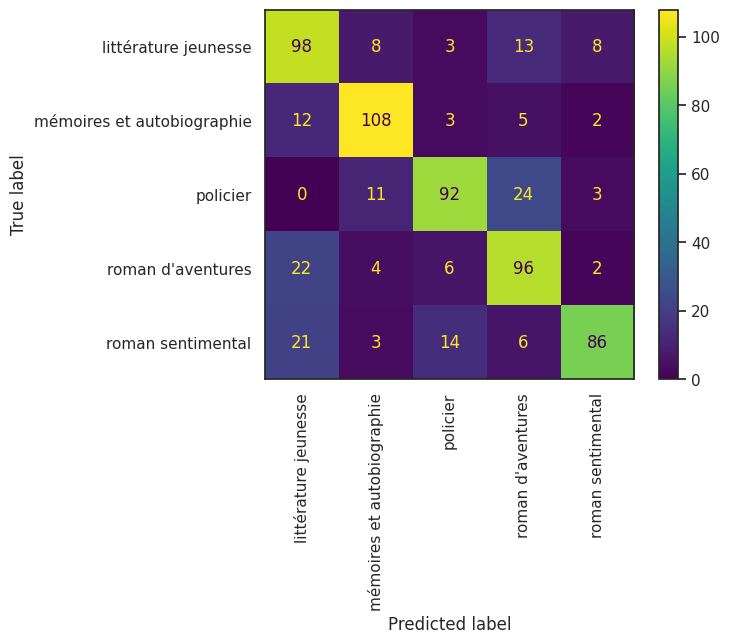

In [144]:
pipe, df_scores, bas = GKF_canonized(df_ALL_balanced, kernel='linear')

0.8476923076923077


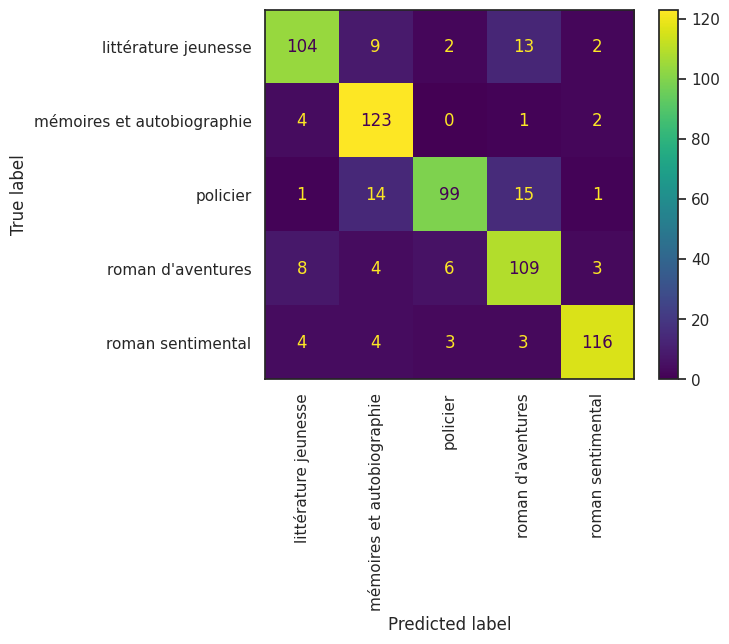

In [108]:
pipe, df_scores, bas = KF_canonized(df_ALL_balanced)

0.8369230769230768


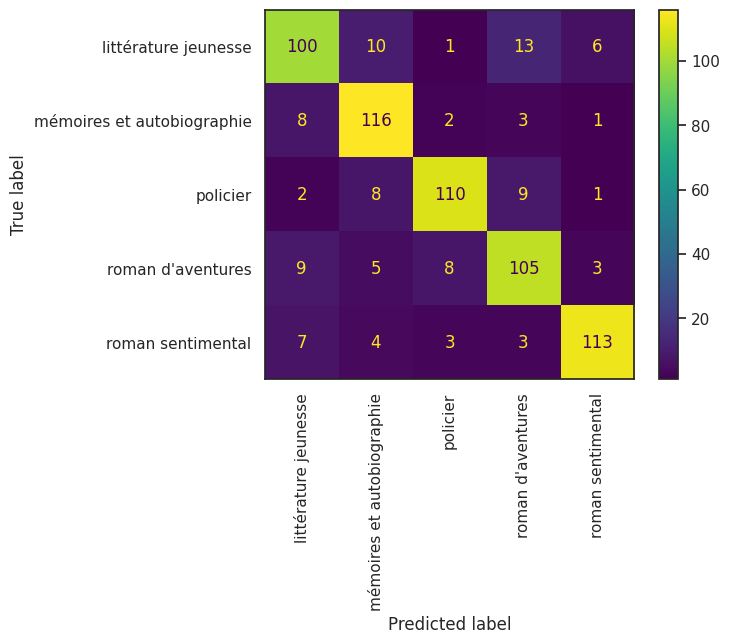

In [109]:
pipe, df_scores, bas = KF_canonized(df_ALL_balanced, kernel="linear")

### RESULTS CHRONOCHAR

                            precision    recall  f1-score     support
littérature jeunesse         0.626506  0.800000  0.702703  130.000000
mémoires et autobiographie   0.816901  0.892308  0.852941  130.000000
policier                     0.771429  0.623077  0.689362  130.000000
roman d'aventures            0.648148  0.807692  0.719178  130.000000
roman sentimental            0.933333  0.538462  0.682927  130.000000
accuracy                     0.732308  0.732308  0.732308    0.732308
0.7323076923076923
\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
littérature jeunesse & 0.626506 & 0.800000 & 0.702703 & 130.000000 \\
mémoires et autobiographie & 0.816901 & 0.892308 & 0.852941 & 130.000000 \\
policier & 0.771429 & 0.623077 & 0.689362 & 130.000000 \\
roman d'aventures & 0.648148 & 0.807692 & 0.719178 & 130.000000 \\
roman sentimental & 0.933333 & 0.538462 & 0.682927 & 130.000000 \\
accuracy & 0.732308 & 0.732308 & 0.732308 & 0.732308 \\
\bottomrul

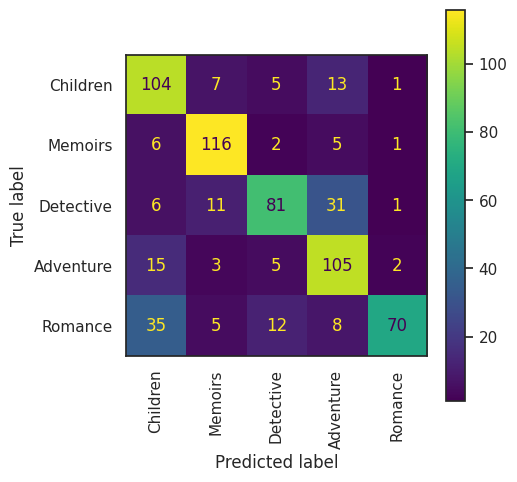

In [212]:
pipe, df_scores, bas, df_probas = GKF_canonized(df_CHRONOCHAR_CONCAT_balanced, 'CHRONO_CHAR', probas=True)
print(df_scores.to_latex())

                            precision    recall  f1-score     support
littérature jeunesse         0.626506  0.800000  0.702703  130.000000
mémoires et autobiographie   0.816901  0.892308  0.852941  130.000000
policier                     0.771429  0.623077  0.689362  130.000000
roman d'aventures            0.648148  0.807692  0.719178  130.000000
roman sentimental            0.933333  0.538462  0.682927  130.000000
accuracy                     0.732308  0.732308  0.732308    0.732308
0.7323076923076923


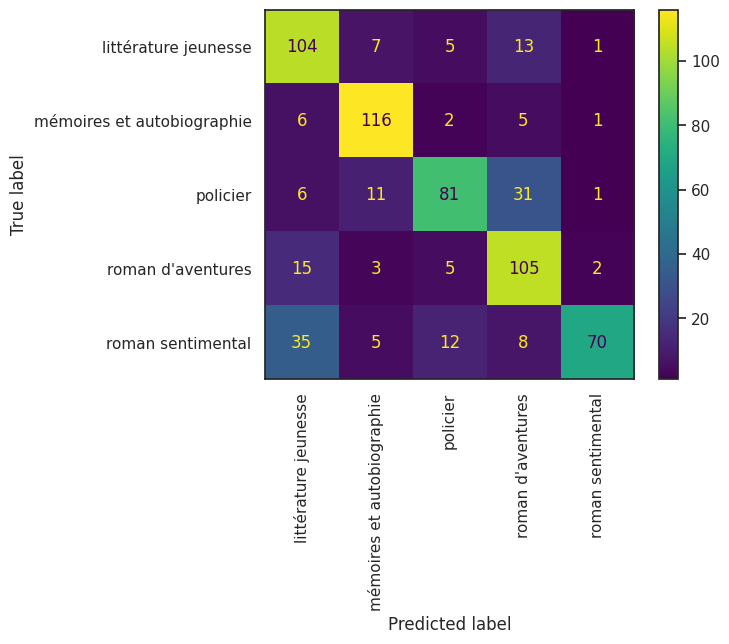

In [146]:
pipe, df_scores, bas = GKF_canonized(df_CHRONOCHAR_CONCAT_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.594118  0.776923  0.673333  130.000000
mémoires et autobiographie   0.833333  0.884615  0.858209  130.000000
policier                     0.810345  0.723077  0.764228  130.000000
roman d'aventures            0.727273  0.738462  0.732824  130.000000
roman sentimental            0.882979  0.638462  0.741071  130.000000
accuracy                     0.752308  0.752308  0.752308    0.752308
0.7523076923076923


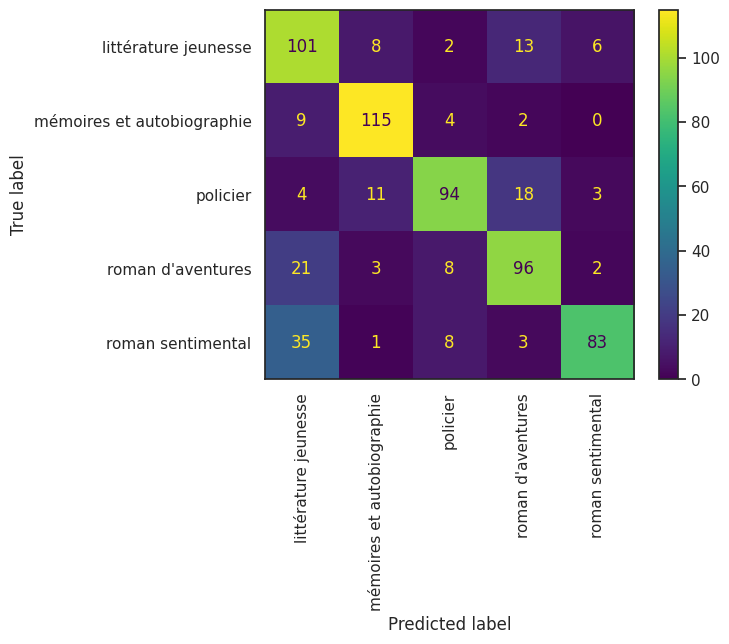

In [147]:
pipe, df_scores, bas = GKF_canonized(df_CHRONOCHAR_CONCAT_balanced, kernel='linear')

0.8323076923076924


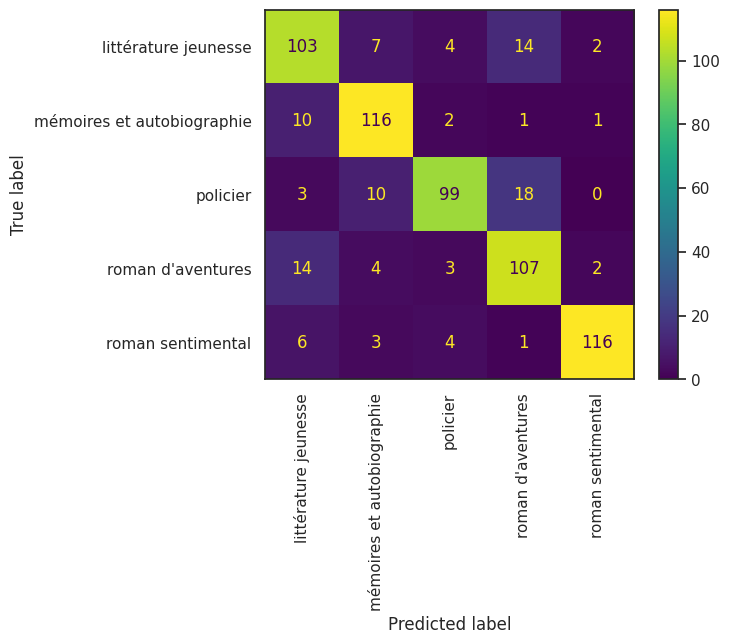

In [110]:
pipe, df_scores, bas = KF_canonized(df_CHRONOCHAR_CONCAT_balanced)

0.836923076923077


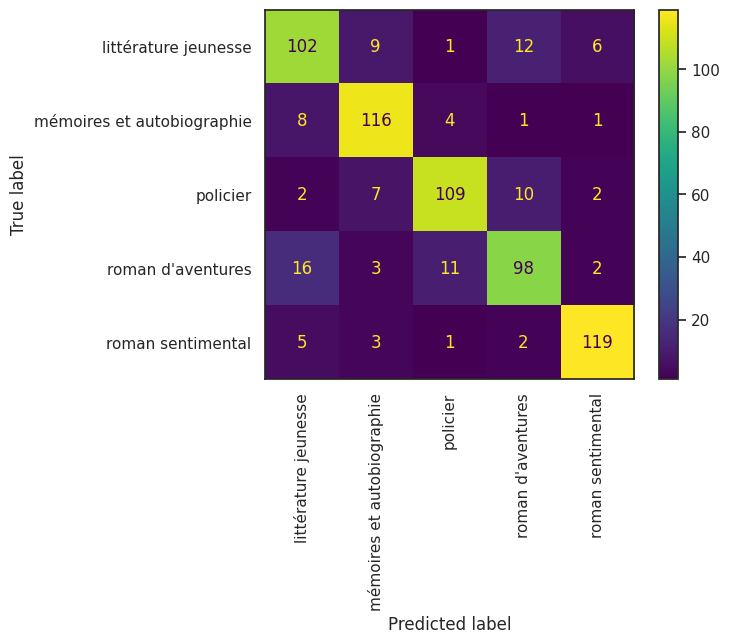

In [111]:
pipe, df_scores, bas = KF_canonized(df_CHRONOCHAR_CONCAT_balanced, kernel="linear")

### RESULTS MAIN CONCAT

                            precision    recall  f1-score     support
littérature jeunesse         0.570588  0.746154  0.646667  130.000000
mémoires et autobiographie   0.784173  0.838462  0.810409  130.000000
policier                     0.765306  0.576923  0.657895  130.000000
roman d'aventures            0.615819  0.838462  0.710098  130.000000
roman sentimental            0.924242  0.469231  0.622449  130.000000
accuracy                     0.693846  0.693846  0.693846    0.693846
0.693846153846154


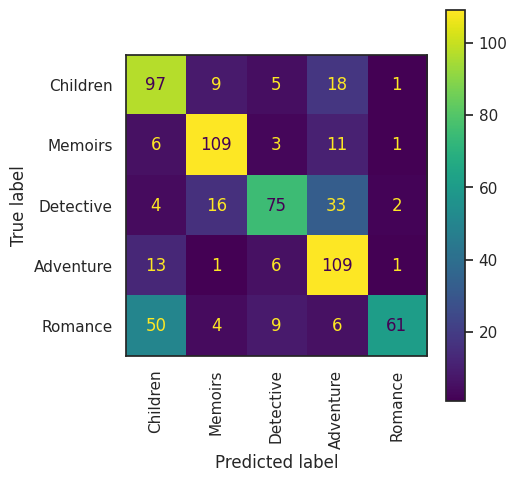

In [208]:
pipe, df_scores, bas, df_probas = GKF_canonized(df_MAIN_CONCAT_balanced, 'ALL_CONCAT', probas=True)

                            precision    recall  f1-score     support
littérature jeunesse         0.570588  0.746154  0.646667  130.000000
mémoires et autobiographie   0.784173  0.838462  0.810409  130.000000
policier                     0.765306  0.576923  0.657895  130.000000
roman d'aventures            0.615819  0.838462  0.710098  130.000000
roman sentimental            0.924242  0.469231  0.622449  130.000000
accuracy                     0.693846  0.693846  0.693846    0.693846
0.693846153846154


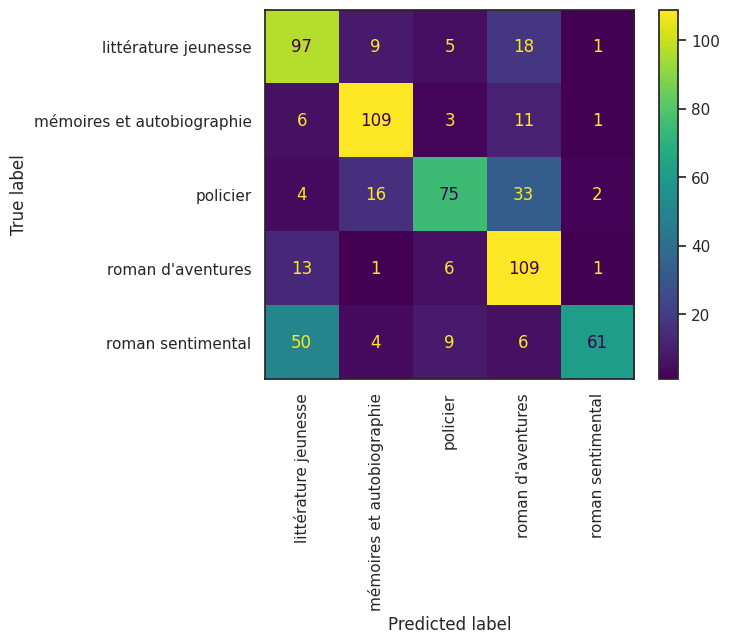

In [148]:
pipe, df_scores, bas = GKF_canonized(df_MAIN_CONCAT_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.608434  0.776923  0.682432  130.000000
mémoires et autobiographie   0.811594  0.861538  0.835821  130.000000
policier                     0.763636  0.646154  0.700000  130.000000
roman d'aventures            0.706294  0.776923  0.739927  130.000000
roman sentimental            0.870968  0.623077  0.726457  130.000000
accuracy                     0.736923  0.736923  0.736923    0.736923
0.7369230769230769


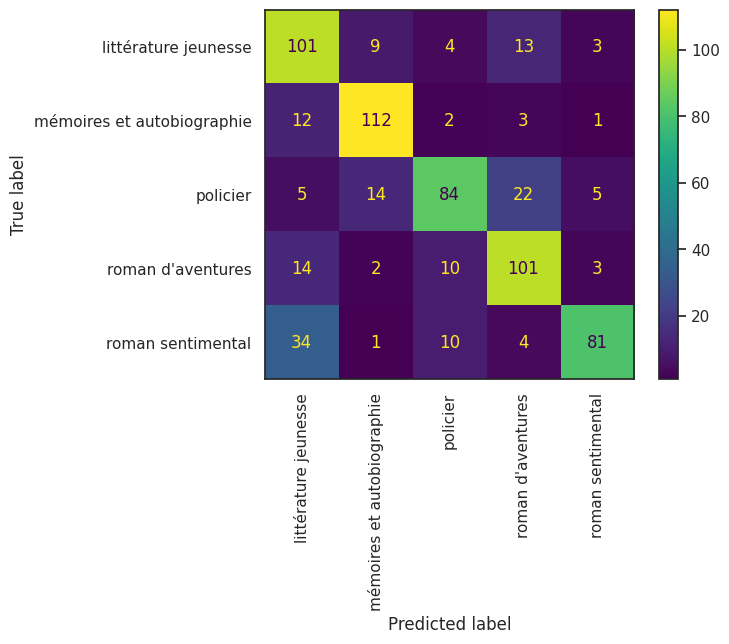

In [149]:
pipe, df_scores, bas = GKF_canonized(df_MAIN_CONCAT_balanced, kernel='linear')

0.8123076923076923


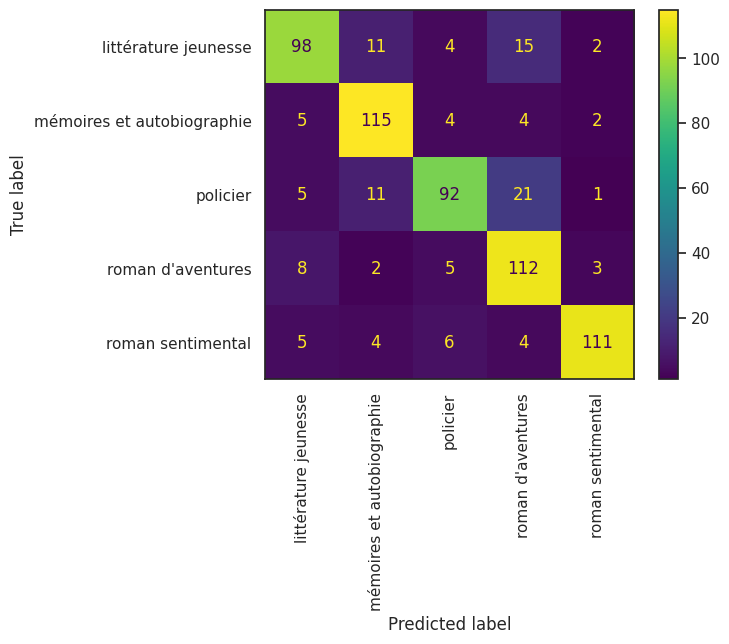

In [112]:
pipe, df_scores, bas = KF_canonized(df_MAIN_CONCAT_balanced)

0.8415384615384616


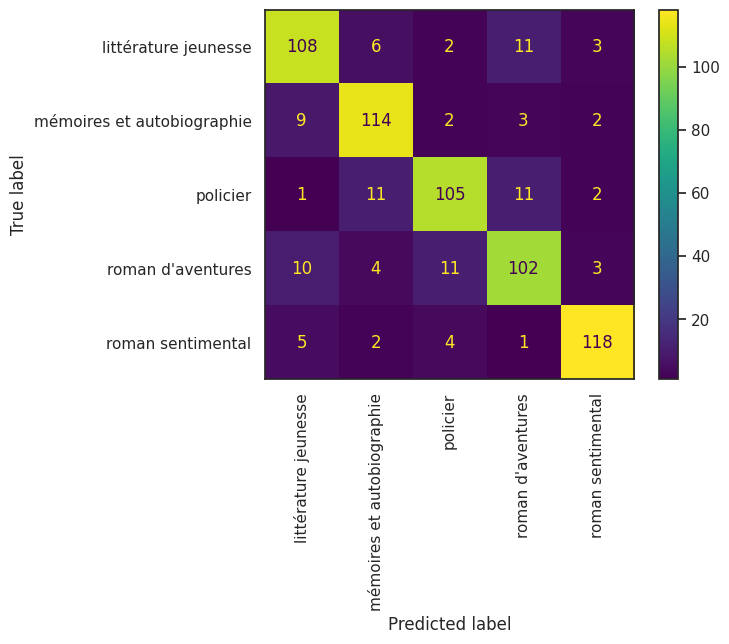

In [113]:
pipe, df_scores, bas = KF_canonized(df_MAIN_CONCAT_balanced, kernel="linear")

                            precision    recall  f1-score     support
littérature jeunesse         0.520468  0.684615  0.591362  130.000000
mémoires et autobiographie   0.691358  0.861538  0.767123  130.000000
policier                     0.691489  0.500000  0.580357  130.000000
roman d'aventures            0.558140  0.738462  0.635762  130.000000
roman sentimental            0.862745  0.338462  0.486188  130.000000
accuracy                     0.624615  0.624615  0.624615    0.624615
0.6246153846153846
                            precision    recall  f1-score     support
littérature jeunesse         0.590361  0.753846  0.662162  130.000000
mémoires et autobiographie   0.770833  0.853846  0.810219  130.000000
policier                     0.701754  0.615385  0.655738  130.000000
roman d'aventures            0.636986  0.715385  0.673913  130.000000
roman sentimental            0.762500  0.469231  0.580952  130.000000
accuracy                     0.681538  0.681538  0.681538    0.681538
0

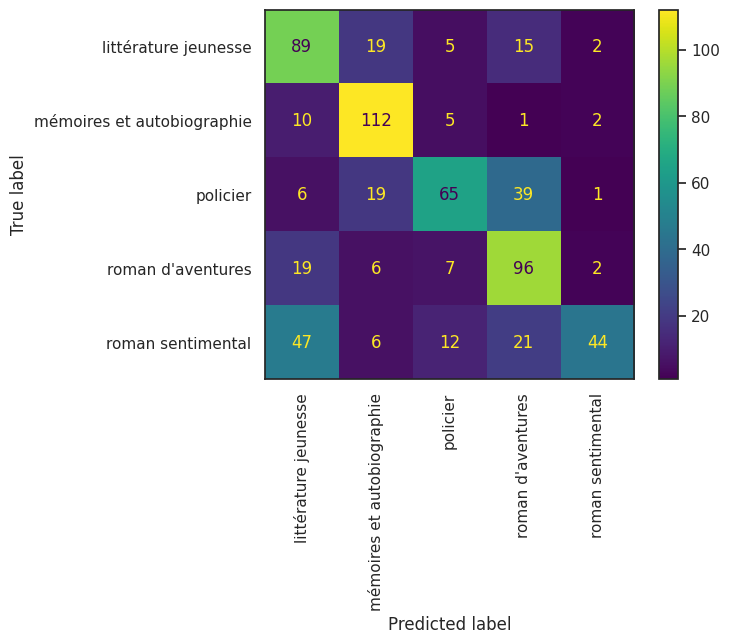

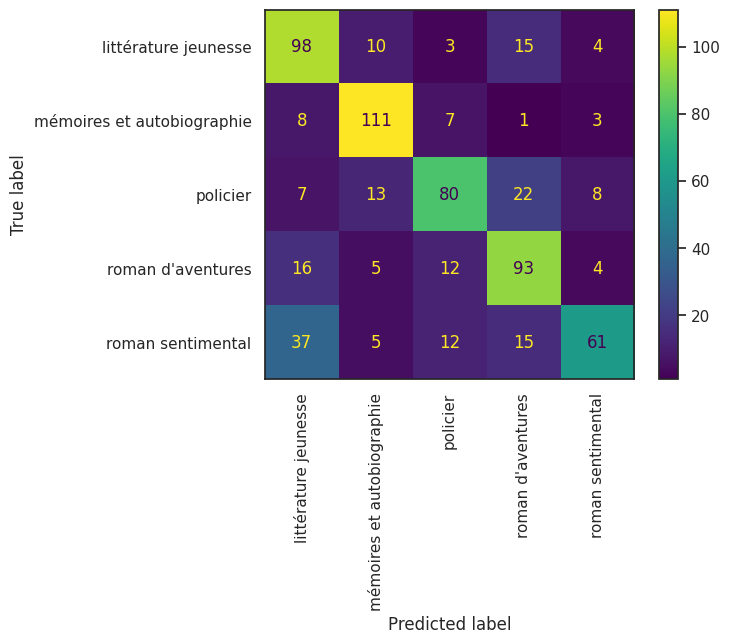

In [153]:
df_TEST_CONCAT = pd.concat([df_AGENT, df_PATIENT, df_ADJ], axis=1)
df_TEST_CONCAT_genred = get_df_with_subgenre(df_TEST_CONCAT, df_corpus, genres_ok)
df_TEST_CONCAT_authored = get_df_with_authors(df_TEST_CONCAT_genred)
df_TEST_CONCAT_balanced = balance_dataframe(df_TEST_CONCAT_authored, 'subgenre', 130)

pipe, df_scores, bas = GKF_canonized(df_TEST_CONCAT_balanced)
pipe, df_scores, bas = GKF_canonized(df_TEST_CONCAT_balanced, kernel='linear')

                            precision    recall  f1-score     support
littérature jeunesse         0.487805  0.769231  0.597015  130.000000
mémoires et autobiographie   0.796296  0.661538  0.722689  130.000000
policier                     0.759259  0.630769  0.689076  130.000000
roman d'aventures            0.601156  0.800000  0.686469  130.000000
roman sentimental            0.857143  0.369231  0.516129  130.000000
accuracy                     0.646154  0.646154  0.646154    0.646154
0.6461538461538461
                            precision    recall  f1-score     support
littérature jeunesse         0.558824  0.730769  0.633333  130.000000
mémoires et autobiographie   0.752000  0.723077  0.737255  130.000000
policier                     0.627119  0.569231  0.596774  130.000000
roman d'aventures            0.697842  0.746154  0.721190  130.000000
roman sentimental            0.775510  0.584615  0.666667  130.000000
accuracy                     0.670769  0.670769  0.670769    0.670769
0

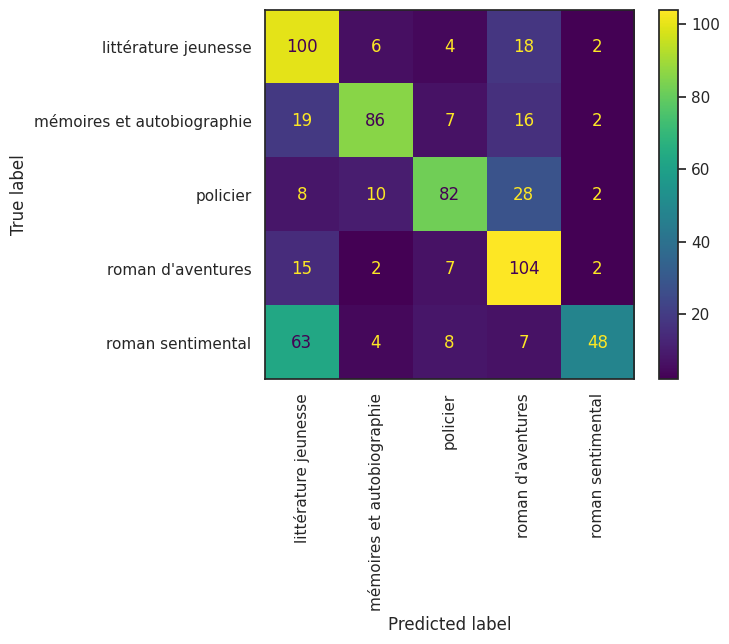

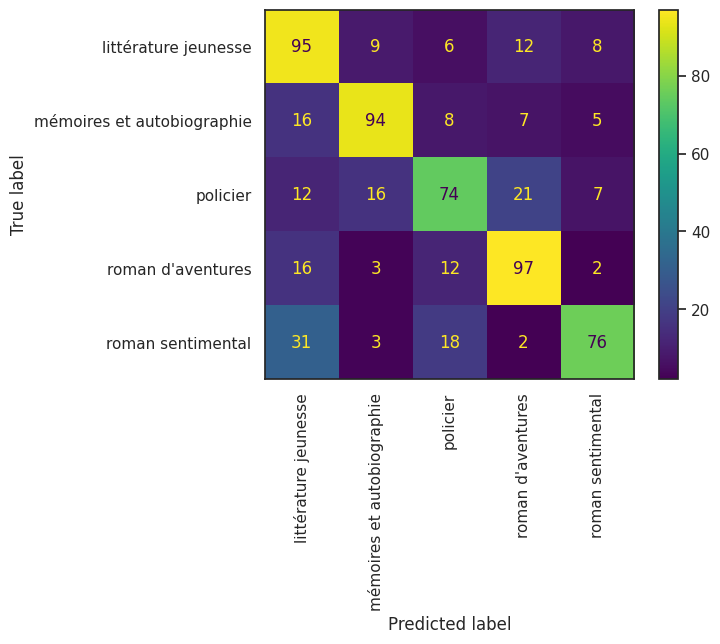

In [164]:
df_TEST_CONCAT = pd.concat([df_LOC, df_FAC, df_GPE, df_VEH, df_TIME], axis=1)
df_TEST_CONCAT_genred = get_df_with_subgenre(df_TEST_CONCAT, df_corpus, genres_ok)
df_TEST_CONCAT_authored = get_df_with_authors(df_TEST_CONCAT_genred)
df_TEST_CONCAT_balanced = balance_dataframe(df_TEST_CONCAT_authored, 'subgenre', 130)
pipe, df_scores, bas = GKF_canonized(df_TEST_CONCAT_balanced)
pipe, df_scores, bas = GKF_canonized(df_TEST_CONCAT_balanced, kernel='linear')

In [ ]:
df_TEST_CONCAT_authored

In [165]:
df_LOC_genred = get_df_with_subgenre(df_LOC, df_corpus, genres_ok)
df_VEH_genred = get_df_with_subgenre(df_VEH, df_corpus, genres_ok)
df_FAC_genred = get_df_with_subgenre(df_FAC, df_corpus, genres_ok)
df_GPE_genred = get_df_with_subgenre(df_GPE, df_corpus, genres_ok)
df_TIME_genred = get_df_with_subgenre(df_TIME, df_corpus, genres_ok)
df_ADJ_genred = get_df_with_subgenre(df_ADJ, df_corpus, genres_ok)
df_AGENT_genred = get_df_with_subgenre(df_AGENT, df_corpus, genres_ok)
df_PATIENT_genred = get_df_with_subgenre(df_PATIENT, df_corpus, genres_ok)

In [166]:
df_LOC_authored = get_df_with_authors(df_LOC_genred)
df_VEH_authored = get_df_with_authors(df_VEH_genred)
df_FAC_authored = get_df_with_authors(df_FAC_genred)
df_GPE_authored = get_df_with_authors(df_GPE_genred)
df_TIME_authored = get_df_with_authors(df_TIME_genred)
df_ADJ_authored = get_df_with_authors(df_ADJ_genred)
df_AGENT_authored = get_df_with_authors(df_AGENT_genred)
df_PATIENT_authored = get_df_with_authors(df_PATIENT_genred)

In [167]:
df_LOC_balanced = balance_dataframe(df_LOC_authored, 'subgenre', 130)
df_VEH_balanced = balance_dataframe(df_VEH_authored, 'subgenre', 130)
df_FAC_balanced = balance_dataframe(df_FAC_authored, 'subgenre', 130)
df_GPE_balanced = balance_dataframe(df_GPE_authored, 'subgenre', 130)
df_TIME_balanced = balance_dataframe(df_TIME_authored, 'subgenre', 130)
df_ADJ_balanced = balance_dataframe(df_ADJ_authored, 'subgenre', 130)
df_AGENT_balanced = balance_dataframe(df_AGENT_authored, 'subgenre', 130)
df_PATIENT_balanced = balance_dataframe(df_PATIENT_authored, 'subgenre', 130)

                            precision    recall  f1-score     support
littérature jeunesse         0.330049  0.515385  0.402402  130.000000
mémoires et autobiographie   0.571429  0.461538  0.510638  130.000000
policier                     0.577778  0.400000  0.472727  130.000000
roman d'aventures            0.543478  0.769231  0.636943  130.000000
roman sentimental            0.235294  0.123077  0.161616  130.000000
accuracy                     0.453846  0.453846  0.453846    0.453846
0.45384615384615384


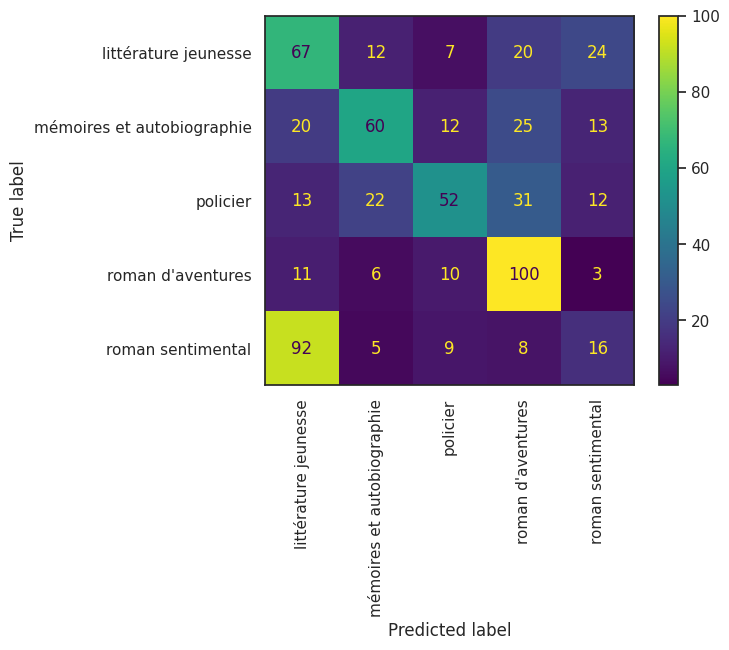

In [168]:
pipe, df_scores, bas = GKF_canonized(df_LOC_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.275449  0.353846  0.309764  130.000000
mémoires et autobiographie   0.463636  0.392308  0.425000  130.000000
policier                     0.579439  0.476923  0.523207  130.000000
roman d'aventures            0.558824  0.730769  0.633333  130.000000
roman sentimental            0.218750  0.161538  0.185841  130.000000
accuracy                     0.423077  0.423077  0.423077    0.423077
0.4230769230769231


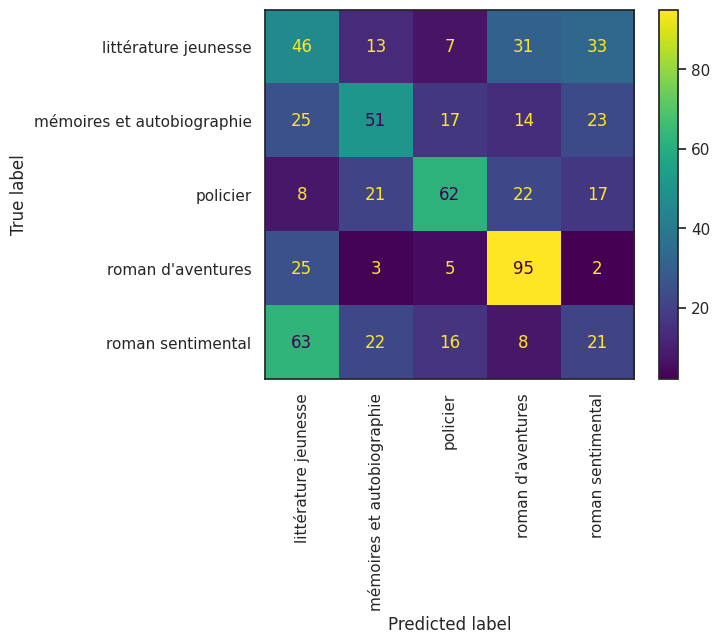

In [169]:
pipe, df_scores, bas = GKF_canonized(df_VEH_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.472222  0.653846  0.548387  130.000000
mémoires et autobiographie   0.600000  0.600000  0.600000  130.000000
policier                     0.682927  0.646154  0.664032  130.000000
roman d'aventures            0.595238  0.769231  0.671141  130.000000
roman sentimental            0.734694  0.276923  0.402235  130.000000
accuracy                     0.589231  0.589231  0.589231    0.589231
0.5892307692307692


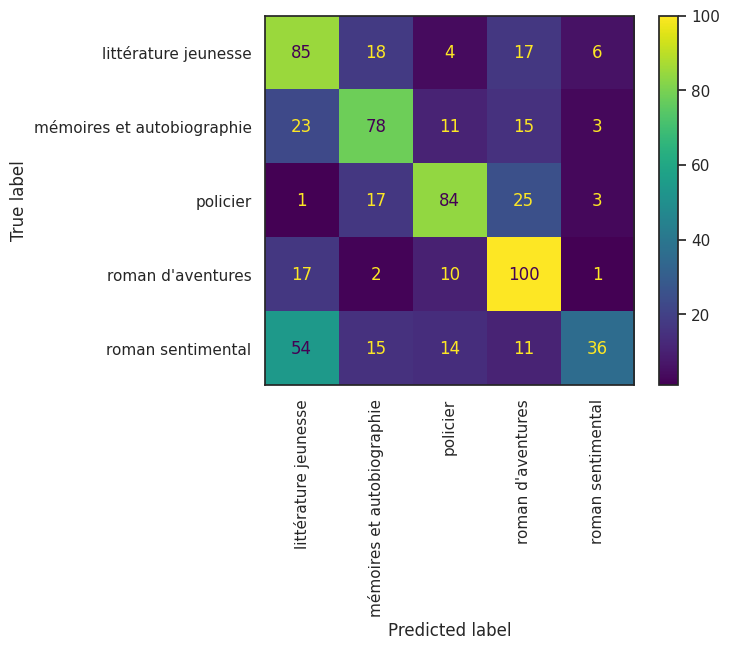

In [170]:
pipe, df_scores, bas = GKF_canonized(df_FAC_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.368932  0.584615  0.452381  130.000000
mémoires et autobiographie   0.566038  0.461538  0.508475  130.000000
policier                     0.562500  0.346154  0.428571  130.000000
roman d'aventures            0.482587  0.746154  0.586103  130.000000
roman sentimental            0.473684  0.207692  0.288770  130.000000
accuracy                     0.469231  0.469231  0.469231    0.469231
0.46923076923076923


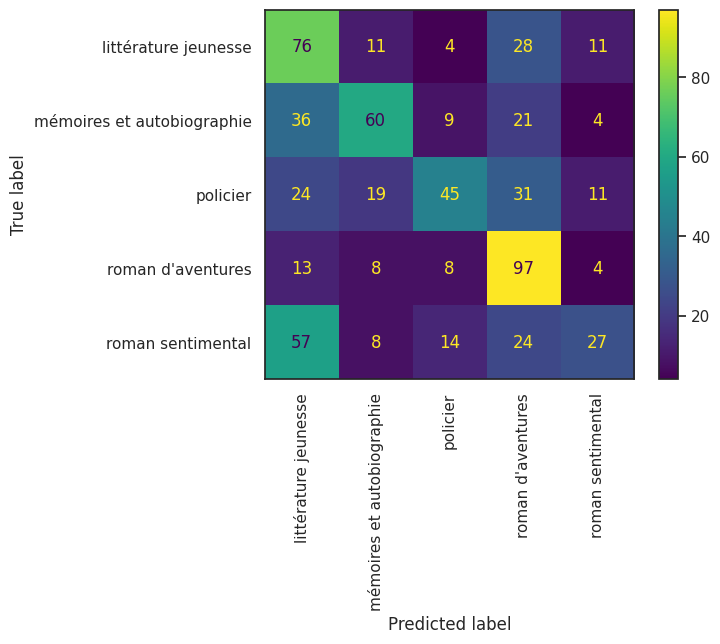

In [171]:
pipe, df_scores, bas = GKF_canonized(df_GPE_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.409756  0.646154  0.501493  130.000000
mémoires et autobiographie   0.659091  0.669231  0.664122  130.000000
policier                     0.487179  0.438462  0.461538  130.000000
roman d'aventures            0.503448  0.561538  0.530909  130.000000
roman sentimental            0.431373  0.169231  0.243094  130.000000
accuracy                     0.496923  0.496923  0.496923    0.496923
0.49692307692307686


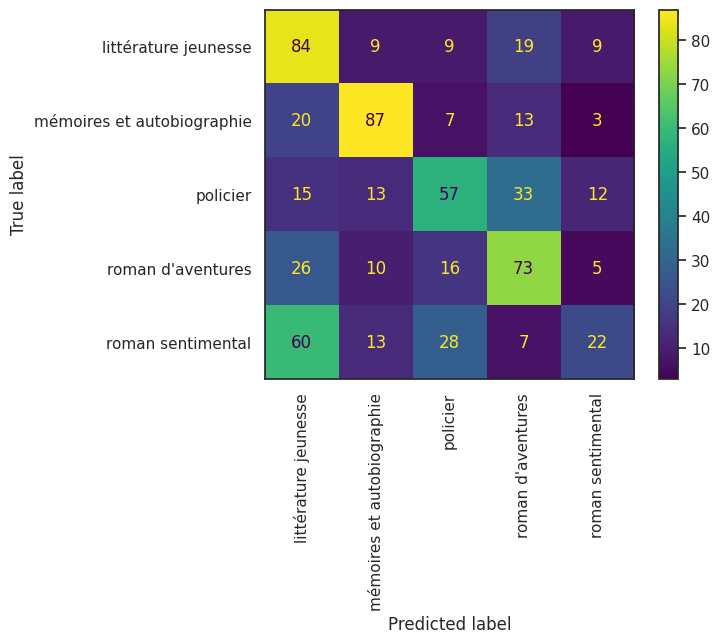

In [172]:
pipe, df_scores, bas = GKF_canonized(df_TIME_balanced)

                            precision    recall  f1-score  support
littérature jeunesse         0.427673  0.523077  0.470588    130.0
mémoires et autobiographie   0.519231  0.623077  0.566434    130.0
policier                     0.522124  0.453846  0.485597    130.0
roman d'aventures            0.541667  0.600000  0.569343    130.0
roman sentimental            0.500000  0.300000  0.375000    130.0
accuracy                     0.500000  0.500000  0.500000      0.5
0.4999999999999999


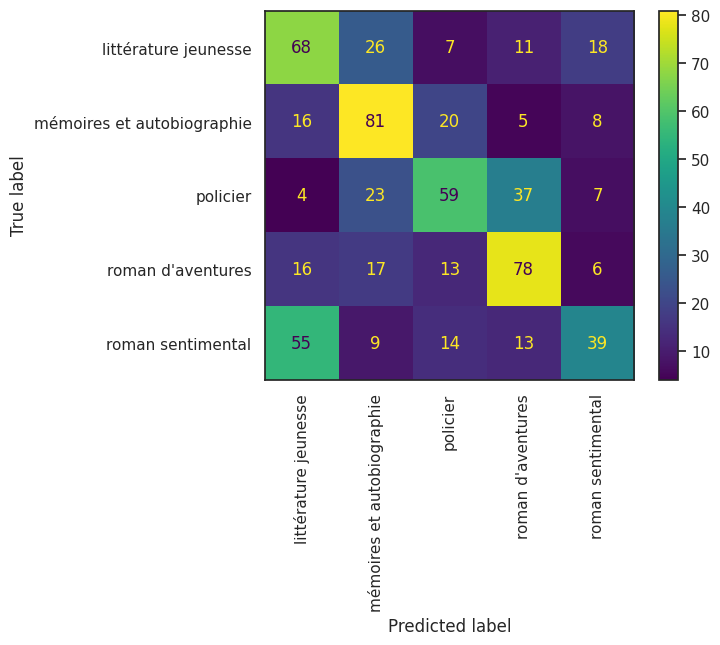

In [173]:
pipe, df_scores, bas = GKF_canonized(df_ADJ_balanced)

                            precision    recall  f1-score     support
littérature jeunesse         0.533333  0.738462  0.619355  130.000000
mémoires et autobiographie   0.723270  0.884615  0.795848  130.000000
policier                     0.652174  0.461538  0.540541  130.000000
roman d'aventures            0.529762  0.684615  0.597315  130.000000
roman sentimental            0.882353  0.346154  0.497238  130.000000
accuracy                     0.623077  0.623077  0.623077    0.623077
0.6230769230769231


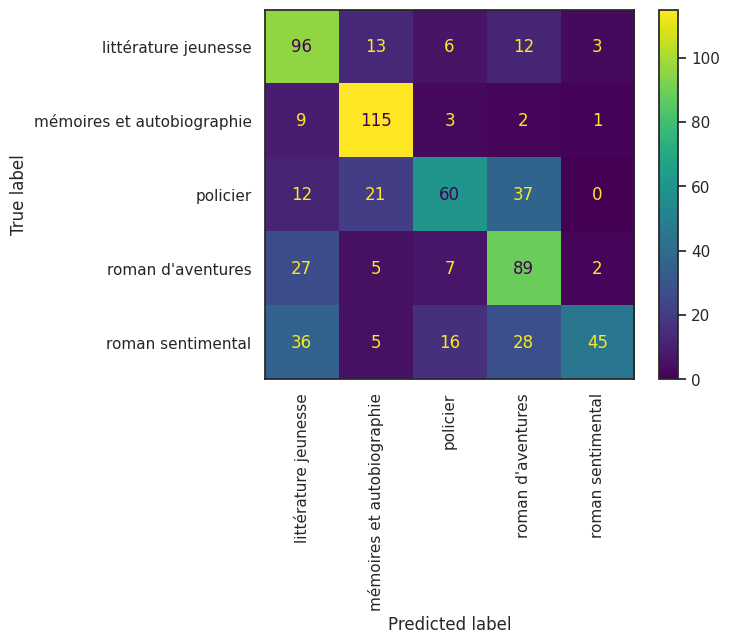

In [174]:
pipe, df_scores, bas = GKF_canonized(df_AGENT_balanced)

                            precision    recall  f1-score  support
littérature jeunesse         0.492958  0.538462  0.514706   130.00
mémoires et autobiographie   0.597826  0.846154  0.700637   130.00
policier                     0.539474  0.315385  0.398058   130.00
roman d'aventures            0.446237  0.638462  0.525316   130.00
roman sentimental            0.548387  0.261538  0.354167   130.00
accuracy                     0.520000  0.520000  0.520000     0.52
0.5199999999999999


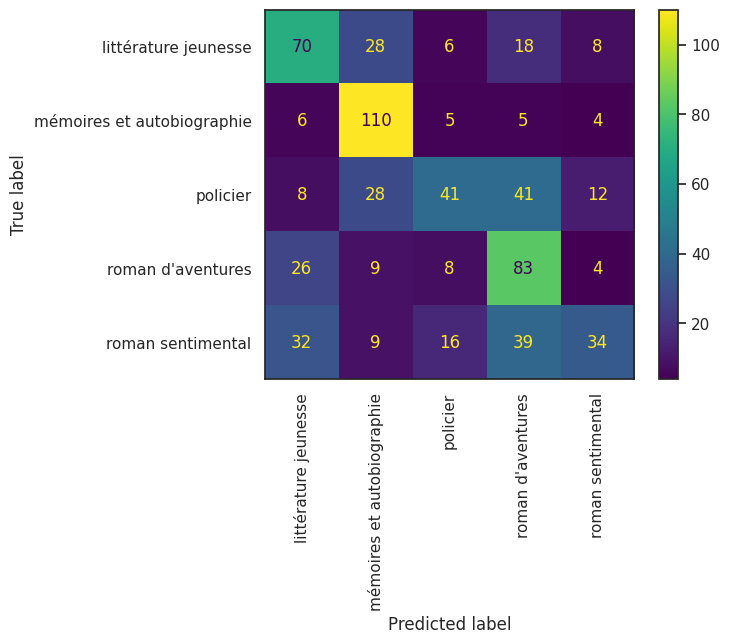

In [175]:
pipe, df_scores, bas = GKF_canonized(df_PATIENT_balanced)